In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from clean_functions import load_neural_data, make_a_plot_beautiful, transpose_neural_data, select_contents, generate_times

In [8]:
# Load the neural data
neural_data_path = "mag_wm_data.mat"
contents = [f"r{i}" for i in range(1, 7)]

neural_data = load_neural_data(file_path=neural_data_path, contents=contents)

# preprocess neural data
neural_data = transpose_neural_data(neural_data) # reps, imgs, ns, tb

# only select the time bins between 180ms-540ms (6-18)

for key, value in neural_data.items():
    neural_data[key] = value[:, :, :, 6:19]

for key, value in neural_data.items():
    print(f"{key}: {value.shape}")


# take average over reps, imgs
for key, value in neural_data.items():
    neural_data[key] = np.nanmean(value, axis=(0, 1)) # reps, images

for key, value in neural_data.items():
    print(f"{key}: {value.shape}")

r1: (16, 200, 192, 13)
r2: (16, 200, 192, 13)
r3: (16, 200, 192, 13)
r4: (16, 200, 192, 13)
r5: (16, 200, 192, 13)
r6: (16, 200, 192, 13)
r1: (192, 13)
r2: (192, 13)
r3: (192, 13)
r4: (192, 13)
r5: (192, 13)
r6: (192, 13)


In [21]:
!pip install --no-index seaborn

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/seaborn-0.13.2+computecanada-py3-none-any.whl


In [23]:
from scipy.stats import shapiro, kruskal
import seaborn as sns

In [15]:
# first we want to perform statistic on the first sliding window
r4 = np.nanmean(neural_data["r4"][:, 9:13], axis=1)
r5 = np.nanmean(neural_data["r5"][:, 9:13], axis=1)
r6 = np.nanmean(neural_data["r6"][:, 9:13], axis=1)

shapiro(r4).pvalue, shapiro(r5).pvalue, shapiro(r6).pvalue

# I checked and non of the sliding windows wasn't normal, so we select Kruskal-Wallis test (non-parametric) over ANOVA

(1.4950351092068096e-13, 2.0334484489191755e-13, 4.524785897223965e-14)

In [18]:
# Kruskal-Wallis test (non-parametric)
# first we want to perform statistic on the first sliding window
r4 = np.nanmean(neural_data["r4"][:, 9:13], axis=1)
r5 = np.nanmean(neural_data["r5"][:, 9:13], axis=1)
r6 = np.nanmean(neural_data["r6"][:, 9:13], axis=1)

kw_stat, kw_p = kruskal(r4, r5, r6)
kw_stat, kw_p

(1.1419462648034369, 0.5649753752568307)

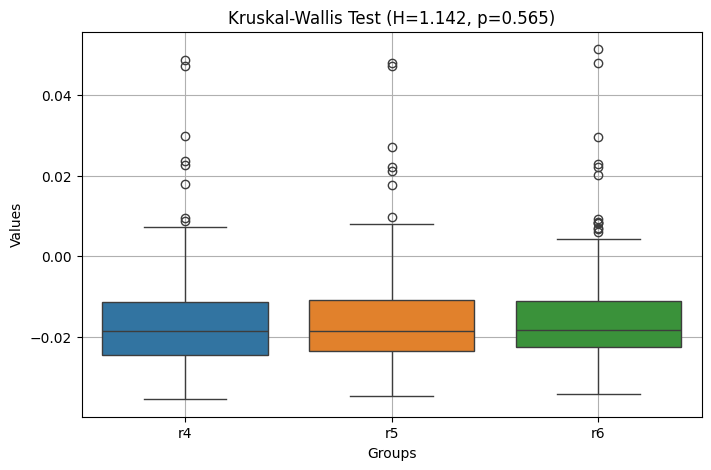

In [24]:
# Kruskal-Wallis test
kw_stat, kw_p = kruskal(r4, r5, r6)

# Visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=[r4, r5, r6])
plt.xticks([0, 1, 2], ["r4", "r5", "r6"])
plt.title(f"Kruskal-Wallis Test (H={kw_stat:.3f}, p={kw_p:.3f})")
plt.ylabel("Values")
plt.xlabel("Groups")
plt.grid(True)

# Show plot
plt.show()

In [25]:
# Define window parameters
window_size = 3
num_windows = 13  # Max index for windows

# Store results
results = []

# Loop through each sliding window
for start in range(0, num_windows - window_size + 1):
    end = start + window_size
    print(f"{start} : {end}")
    
    # Compute mean across the window
    r4 = np.nanmean(neural_data["r4"][:, start:end], axis=1)
    r5 = np.nanmean(neural_data["r5"][:, start:end], axis=1)
    r6 = np.nanmean(neural_data["r6"][:, start:end], axis=1)

    # Normality test
    shapiro_p_values = (shapiro(r4).pvalue, shapiro(r5).pvalue, shapiro(r6).pvalue)
    normality = all(p > 0.05 for p in shapiro_p_values)

    # Choose statistical test
    if normality:
        test_name = "ANOVA not used (data not normal)"
        kw_stat, kw_p = kruskal(r4, r5, r6)
    else:
        test_name = "Kruskal-Wallis"
        kw_stat, kw_p = kruskal(r4, r5, r6)

    # Store results
    results.append({
        "Window Start": start,
        "Window End": end,
        "Shapiro P-values": shapiro_p_values,
        "Test Used": test_name,
        "Kruskal-Wallis H": kw_stat,
        "Kruskal-Wallis P": kw_p
    })

# Print results
for res in results:
    print(res)

0 : 3
1 : 4
2 : 5
3 : 6
4 : 7
5 : 8
6 : 9
7 : 10
8 : 11
9 : 12
10 : 13
{'Window Start': 0, 'Window End': 3, 'Shapiro P-values': (6.217614644327721e-08, 8.894793110581824e-08, 5.188938740367247e-08), 'Test Used': 'Kruskal-Wallis', 'Kruskal-Wallis H': 0.1515866460858888, 'Kruskal-Wallis P': 0.9270077779087136}
{'Window Start': 1, 'Window End': 4, 'Shapiro P-values': (1.4649195860809123e-09, 1.6725835140843947e-09, 1.916700810717418e-09), 'Test Used': 'Kruskal-Wallis', 'Kruskal-Wallis H': 0.9734900797948285, 'Kruskal-Wallis P': 0.6146237174956918}
{'Window Start': 2, 'Window End': 5, 'Shapiro P-values': (3.243253403062995e-11, 2.5831790623286048e-11, 2.7755284551553442e-11), 'Test Used': 'Kruskal-Wallis', 'Kruskal-Wallis H': 1.033081266247791, 'Kruskal-Wallis P': 0.5965807741455023}
{'Window Start': 3, 'Window End': 6, 'Shapiro P-values': (2.8070977835929594e-12, 1.2814427689964508e-12, 8.518355252427803e-13), 'Test Used': 'Kruskal-Wallis', 'Kruskal-Wallis H': 1.0664246792555332, 'Kruskal

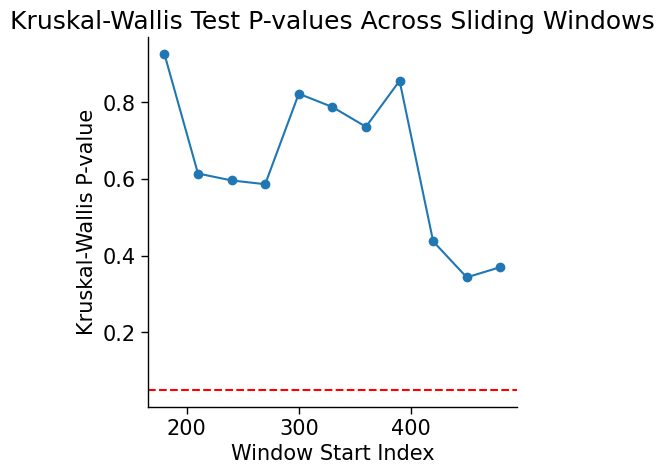

In [30]:
fig, ax = plt.subplots()

# Extracting window start indices and p-values
window_starts = [180 + res["Window Start"]*30 for res in results]
kw_p_values = [res["Kruskal-Wallis P"] for res in results]


ax.plot(window_starts, kw_p_values, marker='o', linestyle='-', label="Kruskal-Wallis P-value")
ax.axhline(y=0.05, color='r', linestyle='--', label="Significance Threshold (0.05)")

make_a_plot_beautiful(ax)

# Labels and title
plt.xlabel("Window Start Index")
plt.ylabel("Kruskal-Wallis P-value")
plt.title("Kruskal-Wallis Test P-values Across Sliding Windows")

plt.show()